gyroDF      w_x   w_y   w_z
0      0   385  -151
1  -1277   139  1320
2 -32768 -5602   401
3   2286   126  1479
4  17857  2624   542
5   2239  -354  -229
--------------------------------------------------


CLICK


C:\Users\cassi\AppData\Local\Temp\ipykernel_17144\175891028.py:140: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax1 = Axes3D(fig1)


Text(0.5, 0, 'Z')

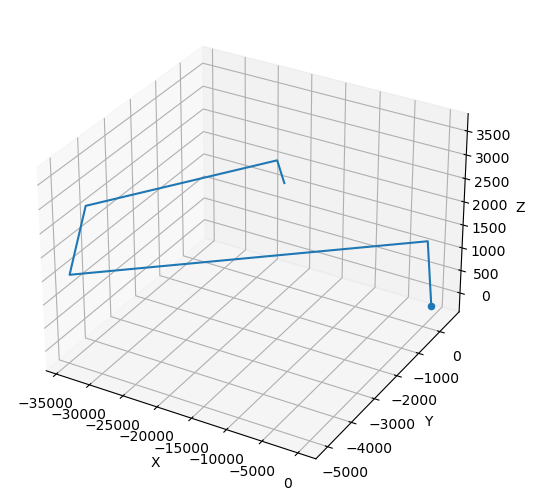

In [79]:
######################################################
# Copyright (c) 2021 Maker Portal LLC
# Author: Joshua Hrisko
######################################################
#
# This code reads data from the MPU9250/MPU9265 board
# (MPU6050 - accel/gyro, AK8963 - mag)
# and solves for calibration coefficients for the
# gyroscope
#
#
######################################################
#
# This code has been altered by Nicole DuPlessis 
# to take in gyroscope data from a csv file 
import time
import math
t0 = time.time()
start_bool = True # if IMU start fails - stop calibration
import numpy as np
import csv,datetime
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
cols = ['w_x','w_y','w_z', 'nAn']
gyro_df = pd.read_csv('gestureData.csv', sep=',', names=cols)
mpu_array = []

time.sleep(2) # wait for MPU to load and settle
# 
#####################################
# Gyro calibration (Steady)
#####################################
#

def get_gyro():
    _,_,_,wx,wy,wz = mpu6050_conv() # read and convert gyro data
    return wx,wy,wz

def gyro_cal():
    print("-"*50)
    #print('Gyro Calibrating - Keep the IMU Steady')
    #[get_gyro() for ii in range(0,cal_size)] # clear buffer before calibration
    #mpu_array = []
    gyro_offsets = [0.0,0.0,0.0]
    for i in range(50):
        try:
            wx,wy,wz = gyro_df['w_x'][i], gyro_df['w_y'][i], gyro_df['w_z'][i]  # get gyro vals
        except:
            continue

        mpu_array.append([wx,wy,wz])

        if np.shape(mpu_array)[0]==cal_size:
            for qq in range(0,3):
                gyro_offsets[qq] = np.mean(np.array(mpu_array)[:,qq]) # average
            break
    #print('Gyro Calibration Complete')
    #print("mpu array", mpu_array)
    return gyro_offsets

if __name__ == '__main__':
    if not start_bool:
        print("IMU not Started - Check Wiring and I2C")
    else:
        #
        ###################################
        # Gyroscope Offset Calculation
        ###################################
        #
        gyro_labels = ['w_x','w_y','w_z'] # gyro labels for plots
        gyro_df = gyro_df.drop('nAn', axis=1)
        print("gyroDF", gyro_df)
        cal_size = gyro_df.size # points to use for calibration
       # print(cal_size)
        gyro_offsets = gyro_cal() # calculate gyro offsets
        #print("offsets", gyro_offsets)
 
gyroData = np.zeros((len(mpu_array[0]), len(mpu_array)))
for i in range(0, len(gyroData)):
    for j in range(0, len(gyroData[0])):
        gyroData[i][j] = mpu_array[j][i] - gyro_offsets[i]
        
#print("gyro data", gyroData)

posSum = [0, 0, 0];
pos = np.zeros((len(mpu_array[0]), len(mpu_array)))
for j in range(0, len(pos[0])):
    for i in range(0, len(pos)):
        posSum[i] += gyroData[i][j]
        pos[i][j] = posSum[i]
#print('pos', pos)

# gesture recognition


fromO = np.zeros([3,len(pos[1])-1])
for i in range(0, len(fromO[0])):
    for j in range(0,3):
        fromO[j][i] = pos[j][i+1] - pos[j][0]

#print('fromO', fromO)

xOrigin = pos[0][0]
xMax = max(fromO[0], key=abs)
yOrigin = pos[1][0]
yMax = max(fromO[1], key=abs)
zOrigin = pos[2][0]
zMax = max(fromO[2], key=abs)


xDelta = xMax
yDelta = yMax 
zDelta = zMax

print()
#print(xDelta)
#print(yDelta)
#print(zDelta)
gesture = 0
if zDelta > 10000:
    if abs(zDelta) > 2*abs(xDelta) and abs(zDelta) > 2*abs(yDelta):
        print('\nRIGHT TURN')
        gesture = 1
if zDelta < -10000:
    if abs(zDelta) > 2*abs(xDelta) and abs(zDelta) > 2*abs(yDelta):
        print('\nLEFT TURN')
        gesture = 1
if xDelta < -10000:
    if abs(xDelta) > 2*abs(zDelta) and abs(xDelta) > 2.5*abs(yDelta):
        print('\nCLICK')
        gesture = 1

if gesture == 0:
    print('\nNO GESTURE DETECTED')
    

fig1 = plt.figure()
ax1 = Axes3D(fig1)
ax1.plot(pos[0], pos[1], pos[2])
ax1.scatter(pos[0][0],pos[1][0],pos[2][0])
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
